In [1]:
import os
import sys
from itertools import chain

import light_curve as lc
import numpy as np
from astropy.table import MaskedColumn

from validutils_zwad.read_data import read_data

In [2]:
# SN Ia 
X_sim_Ia, y_sim_Ia = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL90_SNIa-SALT2.pkl.gz')



In [3]:
import matplotlib.pyplot as plt
X_sim_Ia['len_mjd_g'] = [len(j) for j in X_sim_Ia['mjd_g']]
X_sim_Ia['len_mjd_r'] = [len(j) for j in X_sim_Ia['mjd_r']]

Text(0.5, 0, '# of obs (inc. non detections)')

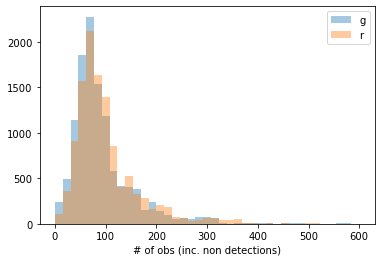

In [5]:
plt.hist(X_sim_Ia['len_mjd_g'], bins=np.linspace(0,600,40), alpha=0.4, slabel='g')
plt.hist(X_sim_Ia['len_mjd_r'], bins=np.linspace(0,600,40), alpha=0.4, label='r')
plt.legend()
plt.xlabel('# of obs (inc. non detections)')

In [6]:
X_sim_Ia.fluxcal_g

18335356    [1505.3767, 2196.2993, 1449.56, 2063.8052, 388...
36517698    [1135.9625, 915.23376, 1112.6862, 1043.9849, 9...
29938315    [1416.482, 1076.9114, 916.9168, 946.9757, 951....
29804380    [1098.0698, 930.42413, 803.45984, 1070.977, 98...
325754      [1015.7258, 1126.3024, 1053.8367, 1368.7179, 1...
                                  ...                        
1130854     [886.25085, 1234.2064, 1056.8531, 1113.39, 982...
324682      [1144.936, 1023.4271, 999.28674, 1146.2003, 10...
764237      [966.5255, 974.7715, 966.5672, 1129.5981, 919....
2370891     [870.5434, 1024.9597, 946.40466, 1091.1237, 11...
24569667    [1031.3105, 1013.742, 1192.8956, 986.781, 1005...
Name: fluxcal_g, Length: 11587, dtype: object

In [7]:
X_sim_Ia

,mjd_g,fluxcal_g,fluxcalerr_g,photflag_g,photprob_g,psf_sig1_g,sky_sig_g,zeropt_g,mag_g,snr_g,...,SIM_SALT2gammaDM,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_SUBSAMPLE_INDEX,len_mjd_g,len_mjd_r
18335356,"[58278.40856, 58343.30885, 58617.45462, 58640....","[1505.3767, 2196.2993, 1449.56, 2063.8052, 388...","[289.38907, 386.36847, 281.7344, 410.5009, 756...","[0, 0, 0, 0, 0, 0, 0]",[],[],[],[],"[20.740963, 19.8054, 20.86803, 19.932844, 18.8...","[5.201913, 5.6844683, 5.1451297, 5.0275292, 5....",...,0.0,19.120863,18.936327,-10.172098,1.0,1.0,1.0,-9,7,44
36517698,"[58244.22882, 58274.25203, 58469.52171, 58487....","[1135.9625, 915.23376, 1112.6862, 1043.9849, 9...","[123.953545, 71.25391, 105.74627, 76.895035, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[22.166452, 22.679443, 22.370323, 23.39174, 22...","[9.164421, 12.844682, 10.522226, 13.576753, 11...",...,0.0,20.059668,19.729494,-9.087266,1.0,1.0,1.0,-9,19,25
29938315,"[58270.46274, 58279.45981, 58282.4189, 58285.4...","[1416.482, 1076.9114, 916.9168, 946.9757, 951....","[269.31384, 93.74818, 65.55841, 40.201843, 92....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[20.95101, 22.785023, 22.701218, 23.188812, 23...","[5.2595963, 11.487278, 13.986258, 23.555529, 1...",...,0.0,17.315933,17.124411,-9.052094,1.0,1.0,1.0,-9,52,58
29804380,"[58202.32795, 58205.2952, 58205.33141, 58233.2...","[1098.0698, 930.42413, 803.45984, 1070.977, 98...","[67.33668, 122.17802, 149.65508, 89.30528, 159...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[22.52116, 22.893854, 21.766373, 22.872204, 24...","[16.307158, 7.6153154, 5.3687444, 11.992314, 6...",...,0.0,20.008600,19.744204,-9.025716,1.0,1.0,1.0,-9,85,80
325754,"[58227.18407, 58231.19788, 58234.15193, 58234....","[1015.7258, 1126.3024, 1053.8367, 1368.7179, 1...","[88.32138, 127.186806, 157.05595, 170.67262, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6144, ...",[],[],[],[],"[24.508469, 22.246471, 23.172304, 21.083263, 2...","[11.5003395, 8.855497, 6.7099442, 8.019551, 8....",...,0.0,20.854347,20.451256,-9.124505,1.0,1.0,1.0,-9,67,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130854,"[58206.2148, 58206.25296, 58227.17402, 58233.2...","[886.25085, 1234.2064, 1056.8531, 1113.39, 982...","[151.19319, 192.83473, 70.98137, 152.92204, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[22.36013, 21.576004, 23.113113, 22.363564, 24...","[5.8617115, 6.4003325, 14.889163, 7.280769, 7....",...,0.0,20.691187,20.339083,-9.062430,1.0,1.0,1.0,-9,61,60
324682,"[58202.2931, 58202.33656, 58205.30312, 58205.3...","[1144.936, 1023.4271, 999.28674, 1146.2003, 10...","[96.45038, 71.12125, 144.04611, 134.1335, 62.6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[22.09706, 24.075703, 27.866888, 22.08763, 23....","[11.870727, 14.389893, 6.9372697, 8.54522, 16....",...,0.0,20.464521,20.173569,-9.018937,1.0,1.0,1.0,-9,80,90
764237,"[58202.34843, 58202.36604, 58205.37692, 58211....","[966.5255, 974.7715, 966.5672, 1129.5981, 919....","[64.276726, 48.19355, 147.92644, 220.76251, 69...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[23.688217, 23.995272, 23.68957, 22.218504, 22...","[15.036943, 20.226181, 6.534107, 5.116802, 13....",...,0.0,17.966728,17.536819,-9.015569,1.0,1.0,1.0,-9,94,102
2370891,"[58342.4403, 58345.431, 58348.49932, 58351.457...","[870.5434, 1024.9597, 946.40466, 1091.1237, 11...","[86.87812, 103.76021, 53.81267, 44.14788, 214....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],"[22.219688, 24.006903, 23.177181, 22.600922, 2...","[10.020284, 9.878158, 17.587023, 24.715199, 5....",...,0.0,18.662027,18.521864,-9.099937,1.0,1.0,1.0,-9,52,51


### Real data cut - 100 obs (incl. non detections) in each band!

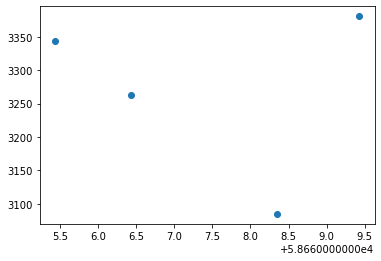

In [6]:
# add background fluxcal to get many mags 21~23 ish...

plt.scatter(X_sim_Ia.loc[18335356].mjd_r, X_sim_Ia.loc[18335356].fluxcal_r)

In [36]:
10**(-0.4*(20-27.5))

1000.0

In [ ]:
X_sim_Ia

In [ ]:
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'


def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('r', 'g',),
        min_obs_count=4,
        cls_name='BaseFeatures'
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    feature_descriptions = (magn_extractor.descriptions 
                            + [replace_magn_with_flux(desc) for desc in flux_extractor.descriptions])
    property_descriptions = {band: [f'{band}-band {desc}'
                             for desc in feature_descriptions]
                      for band in bands}
    output_locus_properties = [
        {
            'name': name,
            'type': 'float',
            'description': desc,
        }
        for name, desc in zip(chain.from_iterable(property_names.values()),
                              chain.from_iterable(property_descriptions.values()))
    ]
    
    features_count = len(feature_names)
    
    return type(
        cls_name,
        (object,),
        {
            '_bands': bands,
            'min_obs_count': min_obs_count,
            'magn_extractor': magn_extractor,
            'flux_extractor': flux_extractor,
            'property_names': property_names,
        }
    )


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)


FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)



def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[photometry['ant_passband'] == band]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections


passbands = ('g', 'r')

class Features(create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)):
    
    def run(self, locus):
        lightcurve = locus.lightcurve
        for band, names in self.property_names.items():
            detections = get_detections(lightcurve, band)
            
            # Ensure locus has >3 obs for calculation
            if (len(detections) < self.min_obs_count):
                continue
            
            # if we have >= 4 observations, calculate features!
            
            t = detections['ant_mjd']
            m = detections['ant_mag']
            merr = detections['ant_magerr']
            flux = np.power(10.0, -0.4 * m)
            fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))
            
            magn_features = self.magn_extractor(
                t,
                m,
                merr,
                sorted=None,
                fill_value=None,
            )
            flux_features = self.flux_extractor(
                t,
                flux,
                fluxerr,
                sorted=None,
                fill_value=None,
            )
            
            # After successfully calculating features, set locus properties and tag
            for name, value in zip(names, chain(magn_features, flux_features)):
                locus.properties[name] = value